In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams["image.interpolation"] = "none"
#rcParams["text.usetex"] = True
plt.rc('text', usetex=False)
sns.set(font_scale=1.5)
sns.set_style("white")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.base import RegressorMixin
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import check_is_fitted

from rate.importance import rate2 #, qr_solve, jth_partition, condition_gaussian, kl_mvn, make_extra_rows
from rate.models import BnnScalarRegressor, BnnBase
from rate.utils import load_mnist, make_square
from rate.projections import CovarianceProjection, PseudoinverseProjection, RidgeProjection
from rate.variational_layers import densevar_layer, prior_standardnormal, posterior_mean_field, posterior_blockdiag

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.layers import Reshape, Conv2D, Dense, BatchNormalization, Flatten, Activation, Lambda
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v1.keras.backend as K
from tensorflow.compat.v1.losses import mean_squared_error
from tensorflow.keras.losses import MeanSquaredError, MSE

from scipy.stats import spearmanr, rankdata, pearsonr
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import time

import logging
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')

In [10]:
# make data
TEST_SIZE = 0.33
n = 5000
p = 100
C = 1
X, y = make_regression(n, p)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE
)

#
# standardise covariates and respones
#
ssX = StandardScaler()
X_train_ = ssX.fit_transform(X_train)
X_test_ = ssX.transform(X_test)

ssY = StandardScaler()
y_train_ = ssY.fit_transform(y_train[:,np.newaxis])
y_test_ = ssY.transform(y_test[:,np.newaxis])

Epoch 1/50
84/84 [==============================] - 1s 10ms/step - loss: 98.2684 - mse: 98.2679 - val_loss: 87.0636 - val_mse: 87.0630
Epoch 2/50
84/84 [==============================] - 0s 6ms/step - loss: 100.1542 - mse: 100.1536 - val_loss: 100.8251 - val_mse: 100.8245
Epoch 3/50
84/84 [==============================] - 0s 6ms/step - loss: 89.7436 - mse: 89.7429 - val_loss: 93.7880 - val_mse: 93.7872
Epoch 4/50
84/84 [==============================] - 0s 6ms/step - loss: 91.8679 - mse: 91.8671 - val_loss: 93.5557 - val_mse: 93.5549
Epoch 5/50
84/84 [==============================] - 0s 6ms/step - loss: 84.5962 - mse: 84.5952 - val_loss: 82.9408 - val_mse: 82.9397
Epoch 6/50
84/84 [==============================] - 0s 6ms/step - loss: 79.4003 - mse: 79.3989 - val_loss: 71.0629 - val_mse: 71.0613
Epoch 7/50
84/84 [==============================] - 0s 6ms/step - loss: 77.6940 - mse: 77.6924 - val_loss: 81.9535 - val_mse: 81.9522
Epoch 8/50
84/84 [==============================] - 0s 6m

DEBUG:__main__:Predicting mean response with X shape (3350, 100) and 5 MC samples
DEBUG:__main__:Predicting mean response with X shape (1650, 100) and 5 MC samples


Text(0.5, 1.0, 'test r^2 = -2.09')

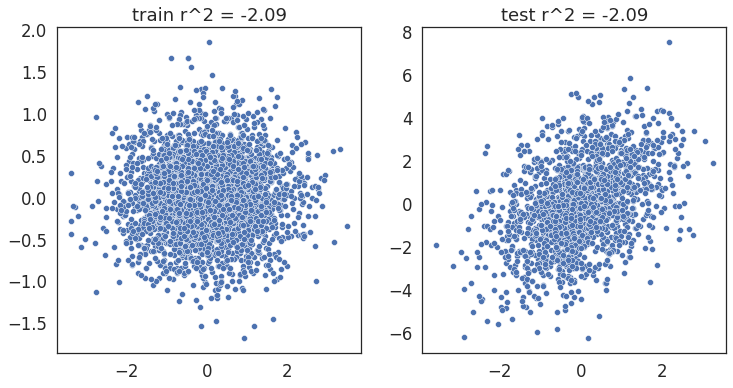

In [72]:
class BnnScalarRegressor(BnnBase, RegressorMixin):
    """Bayesian neural network for scalar regression
    """

    def __init__(self, layer_fn=[], optimiser_fn=Adam, metrics=["mse"], n_mc_samples=100, verbose=0):
        super().__init__(
            layer_fn=layer_fn,
            optimiser_fn=optimiser_fn,
            metrics=metrics,
            n_mc_samples=n_mc_samples,
            verbose=verbose)

    def _nll(self, labels, logits):
        """Negative log likelihood - the reconstruction term in the ELBO
        """
        #  return mean_squared_error(labels=labels, predictions=logits)
        return MSE(labels, logits)

    def predict(self, X, n_mc_samples=None, **kwargs):
        """Returns mean prediction over Monte Carlo samples
        """
        check_is_fitted(self, "_logit_model")
        if n_mc_samples is None: n_mc_samples = self.n_mc_samples
        logger.debug("Predicting mean response with X shape {} and {} MC samples".format(X.shape, n_mc_samples))
        verbosity, kwargs = self._check_verbosity(kwargs)
        return np.mean([self._logit_model.predict(X, verbose=verbosity, **kwargs) for _ in range(n_mc_samples)], axis=0)

    def predict_samples(self, X, n_mc_samples=None, **kwargs):
        check_is_fitted(self, "_logit_model")
        if n_mc_samples is None: n_mc_samples = self.n_mc_samples
        logger.debug("Sampling predicted response with X shape {} and {} MC samples".format(X.shape, n_mc_samples))
        verbosity, kwargs = self._check_verbosity(kwargs)
        return np.array([self._logit_model.predict(X, verbose=verbosity, **kwargs) for _ in range(n_mc_samples)])

    def _get_layers(self, X, y):
        return default_layers(X.shape[1], 1)

    def score(self, X, y, n_mc_samples=None):
        if type_of_target(y) != self.target_type:
            raise ValueError("Label type is {} but model expects {}".format(type_of_target(y), self.target_type))
        if n_mc_samples is None: n_mc_samples = self.n_mc_samples
        return mean_squared_error_score(y, self.predict(X, n_mc_samples))
    
N_MC_SAMPLES = 5 #  CHANGEME BACK TO 100
SEED = 12345
np.random.seed(SEED)
DTYPE = np.float32

N_EPOCHS = 50
OPTIMIZER_FN = lambda: Adam(1e-4)
BETA = 1.0
BNN_FIT_ARGS = {
    'epochs' : N_EPOCHS, # CHANGEME BACK TO 50
    'validation_split' : 0.2,
    'callbacks' : [EarlyStopping(patience=5, monitor='val_mse'), TerminateOnNaN()]
    }

def make_layers(prior, posterior):
    return [
        #Dense(256, activation='relu', input_shape=(p,)),
        #Dense(1024, activation='relu'),
        Lambda(lambda x: x, input_shape=(p,)),
        densevar_layer(C, X_train.shape[0], prior, posterior, 1.0, False)
    ]

bnn = BnnScalarRegressor(
    layer_fn=lambda: make_layers(
        prior_standardnormal(1.0), 
        posterior_mean_field()
    ),
    n_mc_samples=N_MC_SAMPLES,
    verbose=0)

bnn = bnn.fit(X_train_, y_train_, verbose=1, **BNN_FIT_ARGS)

    # plot predictions vs labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train predictions
yhat_train_ = bnn.predict(X_train_)
sns.scatterplot(x=y_train_[:,0], y=yhat_train[:,0], ax=axes[0])
axes[0].set_title("train r^2 = {:.2f}".format(r2_score(y_train_, yhat_train_)))

# test predictions
yhat_test_ = bnn.predict(X_test_)
sns.scatterplot(x=y_test_[:,0], y=yhat_test_[:,0], ax=axes[1])
axes[1].set_title("test r^2 = {:.2f}".format(r2_score(y_test_, yhat_test_)))

Text(0.5, 1.0, 'r^2 = 0.95')

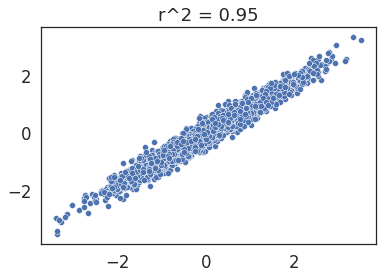

In [73]:
# inspect the weights
b = bnn.post_mean_bias().numpy()
Mw = bnn.post_mean_weights().numpy()
Vb = bnn.post_cov_weights().numpy()

def prediction(X):
    return np.dot(X, Mw) + b

y_train_mean = prediction(X_train_)
ax = sns.scatterplot(x=y_train_[:,0], y=y_train_mean[:,0])
ax.set_title("r^2 = {:.2f}".format(r2_score(y_train_, y_train_mean)))